### Name : Fergal Keane

### Student No. : 21211167

In [431]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#for TSNE dimension reduction
from sklearn.manifold import TSNE, Isomap

## EDA

We start with a brief EDA to check for missing values and outliers.

In [381]:
df = pd.read_csv("./insurance.csv")
df_backup = df.copy(deep=True)  #used below to save me coming all the way back up here to restart
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [382]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

Let's have a look at the three categorical values. 

In [383]:
print(df['gender'].value_counts())
print(df['smoker'].value_counts())
print(df['region'].value_counts())

male      676
female    662
Name: gender, dtype: int64
no     1064
yes     274
Name: smoker, dtype: int64
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


Check for missing values

In [384]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

Let's take a look at the numeric data

In [385]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

We will have to scale this data, but lets have a look to see if there are any outliers

We will create a few box plots, but on separate box plots as the data is all of different scales

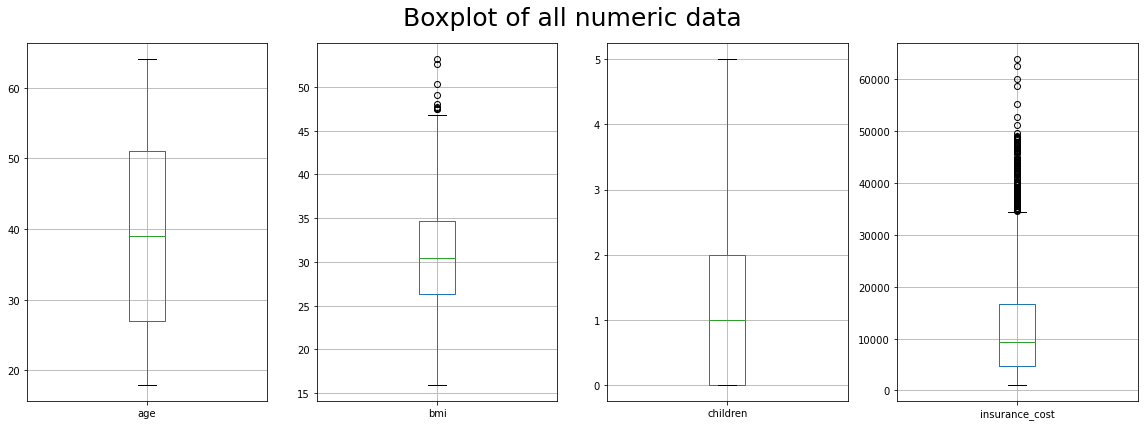

In [386]:
numeric_features = ['age','bmi','children','insurance_cost']

fig, axes = plt.subplots(1,4, figsize=(16,6))
fig.suptitle('Boxplot of all numeric data',fontsize=25)
plt_num = 0

for feature in numeric_features:
    plt_num+=1
    plt.subplot(1,4,plt_num)
    
    #df.drop(['gender','smoker','region'], axis=1).boxplot(figsize=(20,5))
    df.boxplot(column=feature)

fig.tight_layout()
plt.show()

We see that bmi & insurance_cost have outliers, so we will scale these using robustscaler, while age and children will be scaled using a standard scaler

### Data Prep

First map categorical data

In [387]:
#gender - evenly matched but slightly more males so we will code that as zero
mapper = {'female': 1, 'male': 0}
df['gender'] = df['gender'].replace(mapper)
df['gender'].value_counts()

0    676
1    662
Name: gender, dtype: int64

In [388]:
#smoker - more non smokers
mapper = {'yes' : 1, 'no' : 0}
df['smoker'] = df['smoker'].replace(mapper)
df['smoker'].value_counts()

0    1064
1     274
Name: smoker, dtype: int64

In [389]:
#one hot encoding for region?
df = pd.get_dummies(df, columns=['region'], 
                        dummy_na=True, 
                        drop_first=True)
df

age  gender     bmi  children  smoker  insurance_cost  region_northwest  \
0      18       0  33.770         1       0      1725.55230                 0   
1      18       0  34.100         0       0      1137.01100                 0   
2      18       1  26.315         0       0      2198.18985                 0   
3      18       1  38.665         2       0      3393.35635                 0   
4      18       1  35.625         0       0      2211.13075                 0   
...   ...     ...     ...       ...     ...             ...               ...   
1333   64       1  31.825         2       0     16069.08475                 0   
1334   64       1  26.885         0       1     29330.98315                 1   
1335   64       0  26.410         0       0     14394.55790                 0   
1336   64       0  36.960         2       1     49577.66240                 0   
1337   64       0  23.760         0       1     26926.51440                 0   

      region_southeast  region_southwest  region_nan  
0                    1                 0           0  
1                    1                 0           0  
2                    0                 0           0  
3                    0                 0           0  
4                    0                 0           0  
...                ...               ...         ...  
1333                 0                 0           0  
1334                 0                 0           0  
1335                 0                 0           0  
1336                 1                 0           0  
1337                 1                 0           0  

[1338 rows x 10 columns]

In [390]:
names_no_outliers

['children',
 'region_northwest',
 'region_southwest',
 'region_nan',
 'smoker',
 'gender',
 'age',
 'region_southeast']

In [391]:
# store a list with the names of all predictors
names_all = [c for c in df]

# define column groups with same data preparation
names_outliers = ['bmi', 'insurance_cost']
#names_outliers = ['bmi']
names_no_outliers = list(set(names_all) - set(names_outliers))

Add classes for adding and selecting columns

In [392]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Pre-processing pipeline

In [393]:
#we have outliers so we will use standard or robust scaler as appropriate
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [394]:
class TestTSNE(BaseEstimator, TransformerMixin):
    def __init__(self,n_components,random_state=None,method='exact'):
        self.n_components = n_components
        self.method = method
        self.random_state = random_state

    def fit(self, X, y = None):
        ts = TSNE(n_components = self.n_components,
        method = self.method, random_state = self.random_state)
        self.X_tsne = ts.fit_transform(X)
        return self

    def transform(self, X, y = None):
        return X

In [395]:
df_backup = df.copy(deep=True)

In [396]:
#roll back to here when experimenting below
df = df_backup.copy(deep=True)

In [397]:
#we have outliers so we will use standard or robust scaler as appropriate
preprocess_pipeline = make_pipeline(RobustScaler())


In [398]:
#remote
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values
#also remove target from list of column names
names_all.remove('insurance_cost')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

Random Forest Pipeline

In [399]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=3))])

In [400]:
pd.DataFrame(X_train).describe()

0            1            2            3            4  \
count  1070.000000  1070.000000  1070.000000  1070.000000  1070.000000   
mean     39.109346     0.501869    30.439818     1.071963     0.209346   
std      14.193182     0.500230     6.028711     1.200039     0.407032   
min      18.000000     0.000000    15.960000     0.000000     0.000000   
25%      26.000000     0.000000    26.180000     0.000000     0.000000   
50%      39.000000     1.000000    30.065000     1.000000     0.000000   
75%      51.000000     1.000000    34.320000     2.000000     0.000000   
max      64.000000     1.000000    50.380000     5.000000     1.000000   

                 5            6            7       8  
count  1070.000000  1070.000000  1070.000000  1070.0  
mean      0.236449     0.271963     0.248598     0.0  
std       0.425099     0.445179     0.432402     0.0  
min       0.000000     0.000000     0.000000     0.0  
25%       0.000000     0.000000     0.000000     0.0  
50%       0.000000     0.000000     0.000000     0.0  
75%       0.000000     1.000000     0.000000     0.0  
max       1.000000     1.000000     1.000000     0.0

In [417]:
N_FEATURES_OPTIONS = [2,3,4]
MAX_DEPTH_OPTIONS = [2, 4]
VAR_THRESHOLD_OPTIONS = [0.1,0.2,0.3]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [VarianceThreshold(threshold=.2)],
        'reduce_dim__threshold': VAR_THRESHOLD_OPTIONS
    },
    {
        'reduce_dim': [Isomap()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_neighbors': [6]
    }#,
    #{
    #    'reduce_dim': [TSNE()]
    #}  

]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.854:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=3), 'reduce_dim__n_features_to_select': 3, 'regresson__max_depth': 4}


In [413]:
search.cv_results_

{'mean_fit_time': array([0.03037143, 0.0273746 , 0.02997217, 0.02217903, 0.01735148,
        0.02228723, 0.024999  , 0.01874967, 0.01874928]),
 'std_fit_time': array([0.00621013, 0.00783139, 0.00811704, 0.00171902, 0.00547752,
        0.00735546, 0.00765452, 0.0062485 , 0.0062494 ]),
 'mean_score_time': array([0.00239797, 0.002598  , 0.00219798, 0.00199847, 0.00352407,
        0.        , 0.0031251 , 0.00312467, 0.        ]),
 'std_score_time': array([4.89336913e-04, 4.89259216e-04, 3.98874696e-04, 4.10190833e-07,
        6.09834080e-03, 0.00000000e+00, 6.25019073e-03, 6.24933243e-03,
        0.00000000e+00]),
 'param_reduce_dim': masked_array(data=[PCA(iterated_power=7), PCA(iterated_power=7),
                    PCA(iterated_power=7), PCA(iterated_power=7),
                    PCA(iterated_power=7), PCA(iterated_power=7),
                    VarianceThreshold(threshold=0.1),
                    VarianceThreshold(threshold=0.1),
                    VarianceThreshold(threshold=0.1)],
 

In [414]:
search.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__preprocess', 'estimator__reduce_dim', 'estimator__regresson', 'estimator__preprocess__memory', 'estimator__preprocess__steps', 'estimator__preprocess__verbose', 'estimator__preprocess__robustscaler', 'estimator__preprocess__robustscaler__copy', 'estimator__preprocess__robustscaler__quantile_range', 'estimator__preprocess__robustscaler__unit_variance', 'estimator__preprocess__robustscaler__with_centering', 'estimator__preprocess__robustscaler__with_scaling', 'estimator__regresson__bootstrap', 'estimator__regresson__ccp_alpha', 'estimator__regresson__criterion', 'estimator__regresson__max_depth', 'estimator__regresson__max_features', 'estimator__regresson__max_leaf_nodes', 'estimator__regresson__max_samples', 'estimator__regresson__min_impurity_decrease', 'estimator__regresson__min_impurity_split', 'estimator__regresson__min_samples_leaf', 'estimator__regresson__min_samples_split', 

In [224]:
X_train.shape

(1070, 9)

In [246]:
search.n_features_to_select

AttributeError: 'GridSearchCV' object has no attribute 'n_features_to_select'

### Linear Regression Pipeline

In [420]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [421]:
N_FEATURES_OPTIONS = [2, 3, 4, 5]
NORMALIZE_OPTIONS = [False, True]
VAR_THRESHOLD_OPTIONS = [0.1,0.2,0.3]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [VarianceThreshold()],
        'reduce_dim__threshold': VAR_THRESHOLD_OPTIONS
    },
    {
        'reduce_dim': [Isomap()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_neighbors': [6]
    }#,
    #{
    #    'reduce_dim': [TSNE()]
    #}  
    ]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.746:
Best parameters:  {'reduce_dim': VarianceThreshold(threshold=0.1), 'reduce_dim__threshold': 0.1}


In [230]:
help(search)

Help on GridSearchCV in module sklearn.model_selection._search object:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "score_samples", "predict", "predict_proba",
 |  "decision_function", "transform" and "inverse_transform" if they are
 |  implemented in the estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either e

In [403]:
search.best_index_ 

17

### Set up Ridge Pipeline

In [442]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regression', Ridge(1))])

In [444]:
N_FEATURES_OPTIONS = [2, 3, 4, 5]
NORMALIZE_OPTIONS = [False, True]
ALPHA_OPTIONS = [0.1, 1.0]
VAR_THRESHOLD_OPTIONS = [0.1,0.2,0.3]

param_grid = [
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__normalize': NORMALIZE_OPTIONS,
        'regression__alpha': ALPHA_OPTIONS
    },
    {
        'reduce_dim': [VarianceThreshold()],
        'reduce_dim__threshold': VAR_THRESHOLD_OPTIONS,
        'regression__normalize': NORMALIZE_OPTIONS,
        'regression__alpha': ALPHA_OPTIONS
    },
    {
        'reduce_dim': [Isomap()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_neighbors': [5],
        'regression__normalize': NORMALIZE_OPTIONS,
        'regression__alpha': ALPHA_OPTIONS
    }#,
    #{
    #    'reduce_dim': [TSNE()]
    #} 
    ]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RIDGE_best_params = search.best_params_
RIDGE_best_model = search.best_estimator_

Best CV score = 0.747:
Best parameters:  {'reduce_dim': VarianceThreshold(threshold=0.1), 'reduce_dim__threshold': 0.1, 'regression__alpha': 1.0, 'regression__normalize': False}


In [436]:
search.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('preprocess',
   Pipeline(steps=[('robustscaler', RobustScaler())])),
  ('reduce_dim', 'passthrough'),
  ('regresson', LinearRegression())],
 'estimator__verbose': False,
 'estimator__preprocess': Pipeline(steps=[('robustscaler', RobustScaler())]),
 'estimator__reduce_dim': 'passthrough',
 'estimator__regresson': LinearRegression(),
 'estimator__preprocess__memory': None,
 'estimator__preprocess__steps': [('robustscaler', RobustScaler())],
 'estimator__preprocess__verbose': False,
 'estimator__preprocess__robustscaler': RobustScaler(),
 'estimator__preprocess__robustscaler__copy': True,
 'estimator__preprocess__robustscaler__quantile_range': (25.0, 75.0),
 'estimator__preprocess__robustscaler__unit_variance': False,
 'estimator__preprocess__robustscaler__with_centering': True,
 'estimator__preprocess__robustscaler__with_scaling': True,
 'estimator__regresson__copy_X': True,
 'estimator__regresson__fit_int

In [422]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [423]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

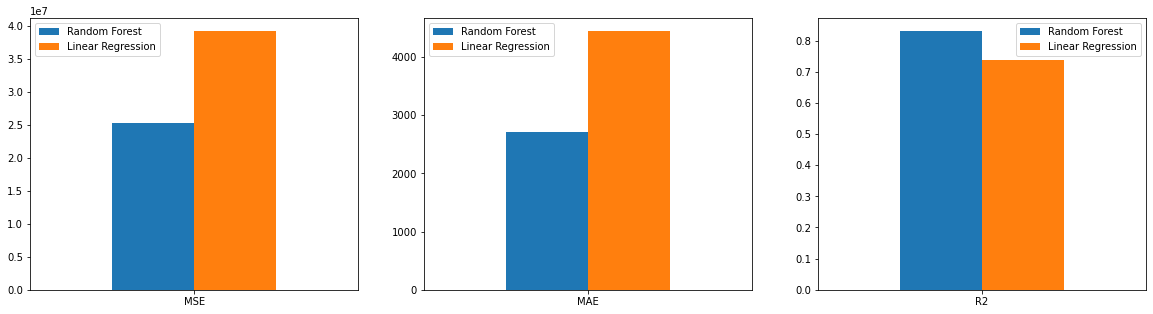

In [424]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

In [445]:
RIDGE_mse, RIDGE_mae, RIDGE_r2 = evaluate_model(X_test, y_test, RIDGE_best_model)

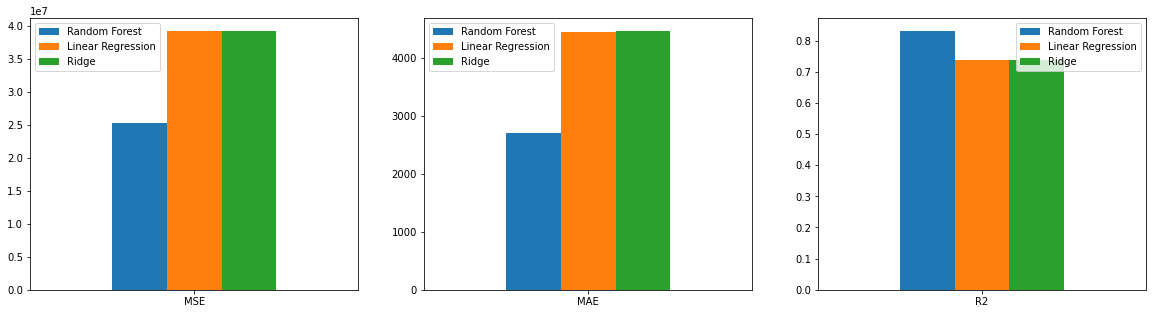

In [446]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Ridge': RIDGE_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'Ridge': RIDGE_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'Ridge': RIDGE_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()